In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv('data.csv')

In [3]:
df.drop(['id','Unnamed: 32'],axis=1,inplace=True)

In [4]:
dic = {'B':0,'M':1}
df['diagnosis'] = df['diagnosis'].map(dic)

<AxesSubplot:>

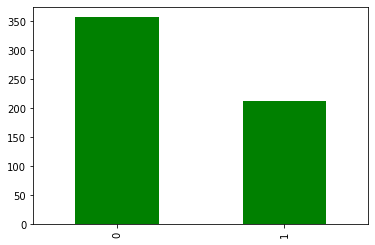

In [5]:
df['diagnosis'].value_counts().plot(kind='bar',color='green')

In [6]:
# it is better if we use an oversample for increse the malignant feature

In [7]:
y = df['diagnosis']
X = df.drop('diagnosis',axis=1)
X = df[['concave points_mean','area_mean','radius_mean','perimeter_mean','concavity_mean']]
# remember feature order whn you deploy :)

In [8]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(0.9)
X_ns,y_ns=os.fit_sample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

The number of classes before fit Counter({0: 357, 1: 212})
The number of classes after fit Counter({0: 357, 1: 321})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=0.9 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [9]:
X = X_ns
y = y_ns

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [12]:
xgb = RandomForestClassifier()

In [13]:
xgb.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [14]:

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(100,2000,2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [15]:
# Create the random grid
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [16]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [17]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 100, cv=cv, scoring='accuracy',error_score=0,return_train_score=True,verbose=2)

In [18]:
xgb_random.fit(X_train,y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=RandomForestClassifier(),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100, 102, 104, 106, 108,
                                                      110, 112, 114, 116, 118,
                                                      120, 122, 124, 126, 128,
                                                      130, 132, 134, 136, 138,
                                                      140, 142, 144, 146, 148,
                                                      150, 152, 154, 156, 158, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                     

In [19]:
## Evaluate

In [20]:
best_model = xgb_random.best_estimator_

In [21]:
best_model

RandomForestClassifier(max_depth=100, max_features='sqrt', n_estimators=1385)

In [22]:
xgb_random.best_params_

{'n_estimators': 1385,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [23]:
xgb_random.best_score_

0.9450797872340425

In [24]:
y_pred = best_model.predict(X_test)

In [25]:
err  =(y_pred- y_test)

<AxesSubplot:>

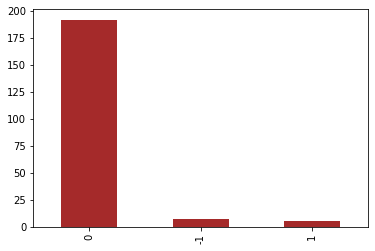

In [26]:
err.value_counts().plot(kind='bar',color='brown')

In [27]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.058823529411764705
MSE: 0.058823529411764705
RMSE: 0.24253562503633297


In [28]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[103   5]
 [  7  89]]
              precision    recall  f1-score   support

           0       0.94      0.95      0.94       108
           1       0.95      0.93      0.94        96

    accuracy                           0.94       204
   macro avg       0.94      0.94      0.94       204
weighted avg       0.94      0.94      0.94       204



In [29]:
import pickle
# open a file, where you ant to store the data
file = open('random_forest_cancer.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()